__Импортирование всего полезного__

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_style("whitegrid")

---

__Другие вспомогательные штуки, которые не обязательно запоминать__

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 12
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 15

In [6]:
def generate_cloud(num, lims, a, b, c, noise_strength=10):
    X = np.linspace(lims[0], lims[1], num).astype(np.float64)
    y = a*np.power(X, 2) + b*X + c
    y += np.random.randn(*y.shape) * noise_strength
    return np.array([X]).T, y

def get_predictions(clf, X):
    tX = np.array([np.linspace(X.min(), X.max(), 100)]).T
    return (tX, clf.predict(tX))

def get_function_values(X, a, b, c):
    tX = np.array([np.linspace(X.min(), X.max(), 100)]).T
    return (tX, a*np.power(tX, 2) + b*X + c)

def plot_function(a, b, c, color='b', label=''):
    tX = np.array([np.linspace(X.min(), X.max(), 100)]).T
    tY = a*np.power(tX, 2) + b*X + c
    plt.plot(tX, tY, color, label=label)

# Первая задача

In [6]:
a = 5
b = 4
c = -20

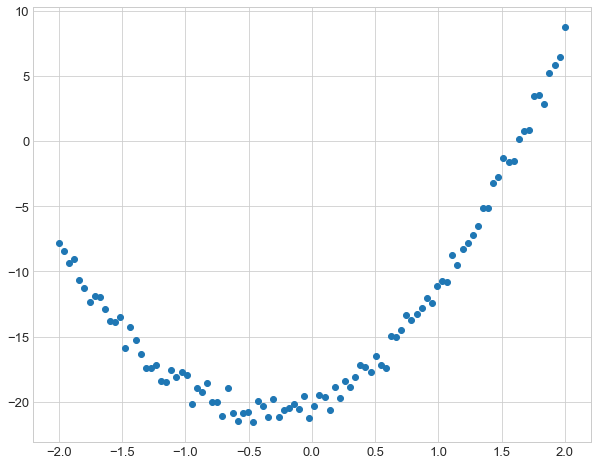

In [7]:
X, y = generate_cloud(100, [-2, 2], a, b, c, noise_strength=0.7)
plt.scatter(X,y);

In [14]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

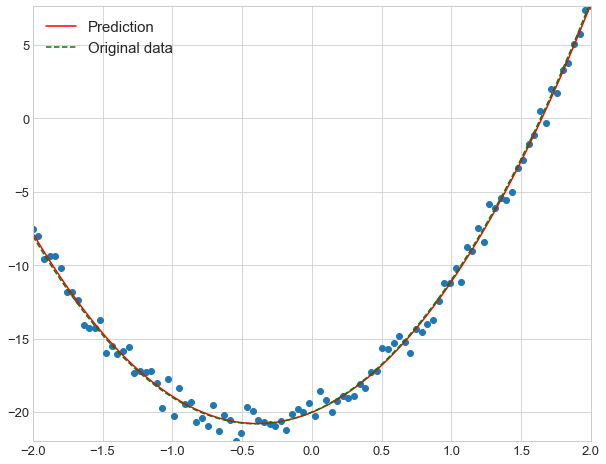

In [16]:
clf = make_pipeline(
    PolynomialFeatures(degree=2),
    SGDRegressor(max_iter=100)
)
clf.fit(X, y);

tX, tY = get_predictions(clf, X)
cX, cY = get_function_values(X, a, b, c)

plt.scatter(X, y);
plt.plot(tX, tY, 'r', label='Prediction');
plt.plot(cX, cY, 'g--', label='Original data');
plt.legend();
plt.xlim([np.min(X), np.max(X)]);
plt.ylim([np.min(y), np.max(y)]);

## Объяснение

Происходит обучение! ✨

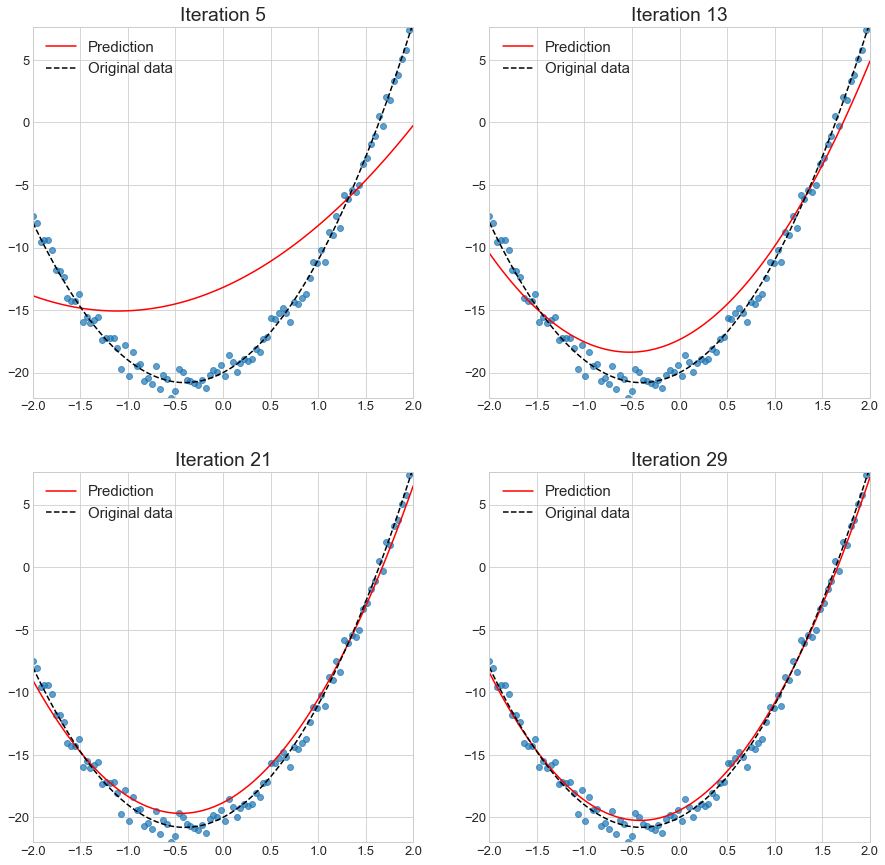

In [23]:
f, axs = plt.subplots(2, 2, figsize=(15, 15))

for i in range(4):
    clf = make_pipeline(
        PolynomialFeatures(degree=2),
        SGDRegressor(max_iter=5 + 8*i),
    )
    clf.fit(X, y);
    tX, tY = get_predictions(clf, X)
    cX, cY = get_function_values(X, a, b, c)
    
    axs[i//2][i%2].set_title('Iteration {}'.format(5 + 8*i));
    axs[i//2][i%2].scatter(X, y, alpha=0.7);
    axs[i//2][i%2].plot(tX, tY, 'r', label='Prediction');
    axs[i//2][i%2].plot(cX, cY, 'k--', label='Original data');
    axs[i//2][i%2].legend();
    axs[i//2][i%2].set_xlim([np.min(X), np.max(X)]);
    axs[i//2][i%2].set_ylim([np.min(y), np.max(y)]);

---

Для начала представим форму нашей будущей функции. Раз мы сказали, что ищем прямую, давайте это формализуем:

$$ \hat{y} = h_\theta(x) = \theta_0 + \theta_1x + \theta_2x^2 = \theta^Tx$$ 

Как понять, хорошо или плохо предсказываем данные? Для этого введем такое понятие, как функция потерь (loss function) и обозначим $L$. Пусть она принимает два значения: истиное и предсказанное, и показывает, насколько одно далеко от другого.

1) Так называемая $\ell_1$-норма

$$ L(y, \hat{y}) = | y - \hat{y} | $$

2) $\ell_2$-норма, или привычное нам Евклидово расстояние:

$$ L(y, \hat{y}) = (y - \hat{y})^2$$

Использовать мы будем далее именно $\ell_2$-расстояние.

Имея на руках функцию потерь, можно пройтись по всей выборке и посмотреть "стоимость" текущего решения $h_\theta$, просуммировав все потери от всех предсказаний. Очевидно, чем меньше выйдет сумма, тем лучше.

Новую функцию так и называют - функцией стоимости (cost function), и обозначают $J$ (или $Q$):

$$ 
J(\theta_0, \theta_1) = \frac{1}{2m}\sum_{i=1}^{M}{L(\hat{y}_i, y_i)}
$$

Теперь если в формулу выше подставить $\ell1$-норму, получится т.н. _средняя абсолютная ошибка_ (_Mean Absolute Error_, или ___MAE___). Если $\ell_2$-норму - _среднеквадратичную ошибку_ (_Mean Squared Error_, ___MSE___). 

Конкретно в нашем случае используется MSE:

\begin{equation}
J(\theta_0, \theta_1) = \frac{1}{2m}\sum_{i=1}^{M}{(\hat{y}_i - y_i)^2} = \frac{1}{2m}\sum_{i=1}^{M}{(h_\theta(x_i) - y_i)^2} 
\end{equation}

Обратите внимание: $J$ - функция от параметров $\theta$, так как мы работаем с теми же данными (обучающей выборкой), меняя лишь коэффициенты нашей модели.

Значит, мы хотим найти такой вектор $\theta$, что $ \underset{\theta}{\mathrm{argmin}} \space J(\theta) $

Давайте подумаем над тем, как выглядит эта функция, если построить график $ J \sim \theta_0, \theta_1 $. Очевидно, функция, которая была изначально нами задана до наложения шума, $5x^2 + 4x - 20$, является лучшей, и, стало быть, $J$ для набора параметров $\theta_0 = -20, \theta = 4, \theta = 5$ принимает свое минимальное значение. 

В то же время, чем больше мы отходим от этого "правильного" набора, тем больше увеличивается $J$. Схематически график функции стоимости $J$ можно нарисовать так:

<img src="images/cost_1.png" width="40%">

Если мы изначально ткнули в некоторое решение, например, $\theta_0 = 0; \theta_1 = 1; \theta = 2$, то как добраться до глобального минимума функции? В математической теории оптимизации для этого существует метод, называемый градиентным спуском.

Суть его заключается в следующем. Мы считаем градиент от $J$:
$$\nabla J(\theta_0, \theta_1, \theta_2) $$

Известно, что он показывает направление наибольшего возрастания функции. Очевидно, что взятый с минусом (т.н. _"антиградиент"_), он будет показывать направление наискорейшего спуска, как раз в сторону глобального минимума функции.

Сколько нужно шагать в эту сторону? Выберем некую константу $\alpha$, и будем величину обновления умножать на $\alpha$. Эта константа называется _"скоростью обучения"_ (англ. _learning rate_). Обычно она мала, равна $10^{-4}-10^{-6}$.

Алгоритм градиентного спуска тогда может быть реализован как
$$ \theta_j \colon= \theta_j - \alpha \frac{\partial}{\partial\theta_j}{J(\theta_0, \theta_1)} $$
то есть по-русски это можно переписать как
$$ \theta_j \colon = \theta_j - \alpha [тангенс\spaceнаклона\spaceкасательной] $$

Применяя к нашей задаче, и зная, что мы имеем дело с линейной регрессией, применяем знания матана, чтобы высчитать произодную от $J$, и получаем ответ:
$$ \theta_0 \colon = \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x_i) - y_i) $$
$$ \theta_1 \colon = \theta_1 - \alpha \frac{1}{m}\sum_{i=1}^{m}((h_\theta(x_i) - y_i)x_i) $$

То есть итеративно мы берем наш текущий набор параметров $\theta$, и обновляем его по формулам выше много-много раз, пока не дойдем до финиша, то есть глобального минимума.

В `sklearn` таким методом пользуется класс __`SGDRegressor`__

Зачем нужно было делать масштабирование? Посмотрите на графики ниже:

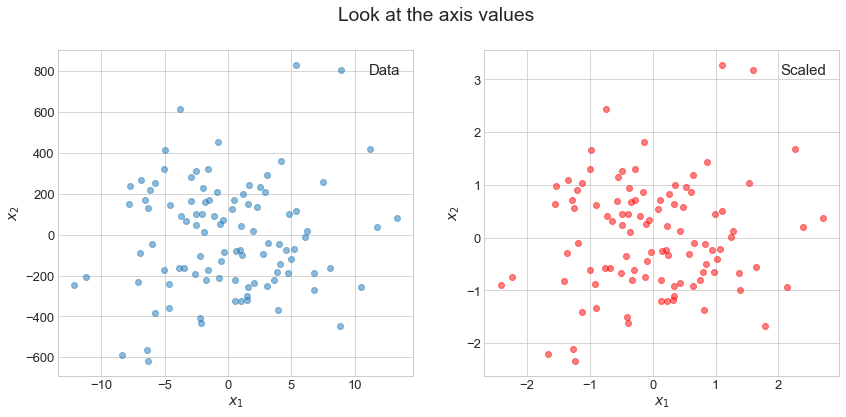

In [26]:
from sklearn.datasets import make_blobs
X = make_blobs(centers=1, cluster_std=5, center_box=(0, 0))[0]
K = 50
X[:, 1] *= K
X_sc = StandardScaler().fit_transform(X)
f,axs = plt.subplots(1,2,figsize=(14,6))
f.suptitle('Look at the axis values');
axs[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data');
axs[0].legend();
axs[0].set_xlabel('$x_1$');
axs[0].set_ylabel('$x_2$');
axs[1].scatter(X_sc[:, 0], X_sc[:, 1], alpha=0.5, label='Scaled', c='red');
axs[1].legend();
axs[1].set_xlabel('$x_1$');
axs[1].set_ylabel('$x_2$');

Видим, что данные раположены в пространстве абсолютно так же, мы просто как будто заменили одни оси на другие, сменив масштаб. 

Если представить, что мы делаем очередной шаг обучения на __не__нормализованных данных (слева), то обновление будет каждый раз огромным и отдавать приоритет коэффициенту, стоящему перед $x_2$, так как те величины не в пример больше.

В нормализованном же случае обновление будет проходить хорошо и равномерно, вне зависимости от величин очередного признака.